In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random, time, pickle, random, multiprocessing, matplotlib, copy, itertools

from joblib import Parallel, delayed
from datetime import datetime
from networkx.utils import py_random_state
from itertools import combinations
import matplotlib as mpl

In [2]:
def components(g):
    components = sorted(nx.connected_components(g), key=len, reverse=True)
    return components

def node_to_comp(comp_list):
    return {n: i for i, s in enumerate(comp_list) for n in s}

def comp_size(g, comp):
    return len(comp)/len(g)

def gc_size(g):
    return comp_size(g, components(g)[0])   


def comp_g(g, compartment_name):
    return [node for node in g.nodes() if g.nodes()[node]['type'] == compartment_name]

def ave_deg(g):
    return np.mean([d for d in dict(g.degree()).values()])

def susceptibility(componentes):
    comp_sizes = [len(i) for i in componentes]
    dist = dict([(key, len(list(group))) for key, group in itertools.groupby(comp_sizes)])
    if len(comp_sizes) > 1:
        numerator = sum([(i**2)*j for i, j in dist.items()])- max(dist)**2
        denominator = sum([i*j for i, j in dist.items()])- max(dist)
        X = numerator/denominator
    else:
        X = 0
    return X

def regular_clique(number_of_nodes, average_degree, clique_size):
    N, K, c = number_of_nodes, average_degree, clique_size
    if K % (c-1) != 0:
        raise Exception('This configuration is not possile')
    else:
        k = int(K/(c-1))
        m = int(N*k/c)
        nodes = [(u, _k) for u in range(N) for _k in range(k)]
        random.shuffle(nodes)
        cliques = [(u, _k) for u in range(m) for _k in range(c)]
        l = list(zip(cliques, nodes))
        my_list = [j[1][0] for j in l]
        node_collections = [my_list[i:i+c] for i in range(0, len(my_list), c)]
        g = nx.Graph()
        for col in node_collections:
            g.add_edges_from(itertools.combinations(col, 2))
        g.remove_edges_from(nx.selfloop_edges(g))
    return g

def make_graph(g, p):
    edgelist = [*g.edges()]
    L = len(edgelist)
    new_g = nx.Graph()
    new_g.add_nodes_from(set(g.nodes()))
    new_g.add_edges_from(random.sample(edgelist, int((p) * L)))
    return new_g

def percolation(g, p_range, ens = 10):
    Gs = lambda g, p_range: [gc_size(make_graph(g, p)) for p in p_range]
    gcc = np.array(Parallel(n_jobs = max(12, multiprocessing.cpu_count()))(delayed(Gs)(g, p_range) for _ in range(ens)))
    return np.mean(gcc, axis = 0), np.std(gcc, axis = 0)

def sus(g, p_range, ens = 10):
    def Ss(g, p_range):
        S = np.array([susceptibility(components(make_graph(g, p))) for p in p_range])
        S /= np.max(S)
        return S
    #scc = np.array([Ss(g, p_range) for _ in range(ens)])
    scc = np.array(Parallel(n_jobs = max(12, multiprocessing.cpu_count()))(delayed(Ss)(g, p_range) for _ in range(ens)))

    return np.mean(scc, axis = 0)


# %%



# %%


def contact_tracing(G, alpha, p):
    '''
        returns number of nodes in different compartments: S, I, Q, R
    '''
    N = len(G)
    infection_seed = random.randint(0, N-1)
    #infection_seed = 0
    compartments = dict([(infection_seed,{'type':'I'})] + [(node,{'type':'S'}) for node in G.nodes() if node != infection_seed])
    nx.set_node_attributes(G, compartments)
    
    new_seeds = {infection_seed} 
    while new_seeds:
        #check if there is no infection left
        t = [quarantine_infection(seed, G, alpha, p) for seed in new_seeds]
        new_seeds = {item for sublist in t for item in sublist}
    
    S, I, R, Q = comp_g(G, 'S'), comp_g(G, 'I'), comp_g(G, 'R'), comp_g(G, 'Q')

    return [len(S), len(I), len(R), len(Q), len(R) + p* len(Q)]

def contact_tracing_ens(g, alpha, p, ens=12):
        C = np.array(Parallel(n_jobs = min(12, multiprocessing.cpu_count()))(delayed(contact_tracing)(copy.deepcopy(g), alpha, p) for en in range(ens)))
        S, I, R, Q , E= np.mean(C, axis = 0)
        return S, I, R, Q, E

def quarantine_infection(infected_node, G, alpha, p):
    new_infected_nodes = []
    for ne in G[infected_node]:
        if G.nodes()[ne]['type'] == 'S':
            if random.random() <= alpha:
                G.nodes()[ne]['type'] = 'Q'
            else:
                if random.random() <= p:
                    G.nodes()[ne]['type'] = 'I'
                    new_infected_nodes.append(ne)
    G.nodes()[infected_node]['type'] = 'R'
    
    return new_infected_nodes


def one_step_SIR(infected_node, G, p, transmission_net):
    new_infected_nodes = []
    for ne in G[infected_node]:
        if G.nodes()[ne]['type'] == 'S'and random.random() <= p:
            G.nodes()[ne]['type'] = 'I'
            transmission_net.nodes()[ne]['type'] = 'I'
            transmission_net.add_edge(infected_node, ne)
            
            new_infected_nodes.append(ne)
    G.nodes()[infected_node]['type'] = 'R'
    transmission_net.nodes()[infected_node]['type'] = 'R'
    
    return new_infected_nodes

   
def plot_e_p_log(N, average_degree, c_1_list, p_range2, ens=12):
    Gs = [regular_clique(N, average_degree, c) for c in c_1_list]
    CT = lambda p_range, G, alpha: [contact_tracing(G, alpha, p)[4] for p in p_range]
    fig, axs = plt.subplots(1,1, figsize=(6, 5))
    cr = ['r', 'g', 'b']
    lins = ['dashed', 'dashdot', 'dotted']
    _i  = 0
    for alpha in [0, 0.25, 0.5]:
        data = [np.mean(np.array(Parallel(n_jobs = max(12, multiprocessing.cpu_count()))(delayed(CT)(p_range2, G, alpha) for en in range(ens))), axis = 0) for G in Gs]
        np.save(str(N)+'_'+str(alpha)+'_subCrit', data)
        #axs.scatter(p_range2, data[0], marker ='*', label = r'$c = 2$', color = colors[0])
        #axs.scatter(p_range2, data[1], marker = 6, label =r'$c = 3$', color = colors[1])
        #axs.scatter(p_range2, data[2], marker= 'h', label = r'$c = 4$', color = colors[2])
        
        axs.plot(p_range2, data[0], color = cr[_i],linestyle=lins[0], label = r'$c = 2$')
        axs.plot(p_range2, data[1], color = cr[_i],linestyle=lins[1], label = r'$c = 3$')
        axs.plot(p_range2, data[2], color = cr[_i],linestyle=lins[2], label = r'$c = 4$')
        
        if alpha == 0:
            axs.legend(fontsize = 15)
        axs.set_yscale('log')

        axs.set_xlabel(r'$p$', fontsize = 15)
        axs.set_ylabel(r'outbreak size', fontsize = 15)
        _i += 1
    plt.savefig(str(N)+'_'+str(alpha)+'_subCrit.pdf')   
    

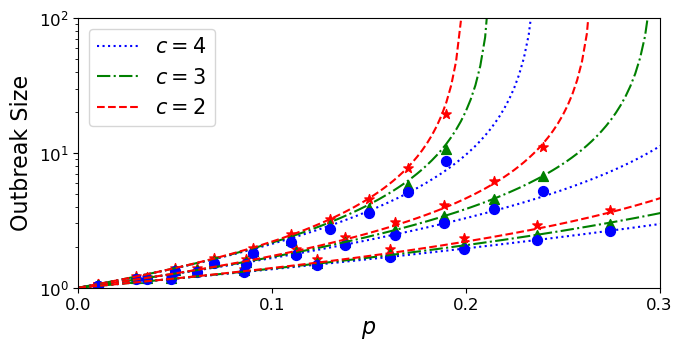

In [3]:
df = pd.read_csv('parsweep_noncc_4.csv')
#df = pd.read_csv('parsweep_noncc_sim_results.csv')

ens = 10**5
N = 10**5
average_degree = 6 
c_1_list = [2,3,4]

data_alpha0 = df[df.alpha < .001]
david_p = data_alpha0['p'].to_numpy(dtype=float)
e2 = data_alpha0['exp_size_2'].to_numpy(dtype=float)
e3 = data_alpha0['exp_size_3'].to_numpy(dtype=float)
e4 = data_alpha0['exp_size_4'].to_numpy(dtype=float)
E1 = [e2, e3, e4]

data_alpha25 = df[(df.alpha > .249) & (df.alpha < .251)]
david_p2 = data_alpha25['p'].to_numpy(dtype=float)
e22 = data_alpha25['exp_size_2'].to_numpy(dtype=float)
e32 = data_alpha25['exp_size_3'].to_numpy(dtype=float)
e42 = data_alpha25['exp_size_4'].to_numpy(dtype=float)
E2 = [e22, e32, e42]

data_alpha5 = df[(df.alpha > .499) & (df.alpha < .501)]
david_p3 = data_alpha5['p'].to_numpy(dtype=float)
e23 = data_alpha5['exp_size_2'].to_numpy(dtype=float)
e33 = data_alpha5['exp_size_3'].to_numpy(dtype=float)
e43 = data_alpha5['exp_size_4'].to_numpy(dtype=float)
E3 = [e23, e33, e43]

Es = [E1, E2, E3]
fig, axs = plt.subplots(figsize = (7.5,3.5))

    
cr = ['r', 'g', 'b']
lins = ['dashed', 'dashdot', 'dotted']
_i  = 0
_c  = 0
pss = [david_p, david_p2, david_p3]



p_range_alpha = []


for alpha in [0, 0.25, 0.5]:
    axs.plot(david_p3, Es[_i][2], color = cr[2],linestyle=lins[2], label = r'$c = 4$', ms = 15)
    axs.plot(david_p2, Es[_i][1],  color = cr[1],linestyle=lins[1], label = r'$c = 3$', ms = 15)
    axs.plot(david_p, Es[_i][0],  color = cr[0],linestyle=lins[0], label = r'$c = 2$', ms = 15)
        
    if alpha == 0:
        axs.legend(fontsize = 15)
        #Y_max = np.max(data[0])
    axs.set_xlim(0.0, .36)
    axs.set_ylim(1, 100)

    
    #axs.set_xscale('log')
    axs.set_yscale('log')

    axs.set_xlabel(r'$p$', fontsize = 16)
    axs.set_ylabel(r'Outbreak Size', fontsize = 16)
    axs.tick_params(axis='y', labelsize= 12)
    axs.tick_params(axis='x', labelsize= 12)
    plt.xticks([0, 0.1, .2, .3])

    _i += 1
    _c += 1

    
df2 = pd.read_csv('parsweep_noncc_sim_results.csv')
data_alpha02 = df2[df2.alpha < .001]
david_ps2 = data_alpha02['p'].to_numpy(dtype=float)
e2S = data_alpha02['exp_size_2'].to_numpy(dtype=float)
e3S = data_alpha02['exp_size_3'].to_numpy(dtype=float)
e4S = data_alpha02['exp_size_4'].to_numpy(dtype=float)
E1S = [e2S, e3S, e4S]

data_alpha252 = df2[(df2.alpha > .249) & (df2.alpha < .251)]
david_p22 = data_alpha252['p'].to_numpy(dtype=float)
e22S = data_alpha252['exp_size_2'].to_numpy(dtype=float)
e32S = data_alpha252['exp_size_3'].to_numpy(dtype=float)
e42S = data_alpha252['exp_size_4'].to_numpy(dtype=float)
E2S = [e22S, e32S, e42S]

data_alpha52 = df2[(df2.alpha > .499) & (df2.alpha < .501)]
david_p32 = data_alpha52['p'].to_numpy(dtype=float)
e23S = data_alpha52['exp_size_2'].to_numpy(dtype=float)
e33S = data_alpha52['exp_size_3'].to_numpy(dtype=float)
e43S = data_alpha52['exp_size_4'].to_numpy(dtype=float)
E3S = [e23S, e33S, e43S]

EsS = [E1S, E2S, E3S]
_i  = 0
_c  = 0

p_range_alpha = []
markers = ['*', '^', 'o']

for alpha in [0, 0.25, 0.5]:
    axs.scatter(david_p32, EsS[_i][2], color = cr[_c], marker = markers[_c],  s = 50)
    axs.scatter(david_p22, EsS[_i][1],  color = cr[_c], marker =  markers[_c],  s = 50)
    axs.scatter(david_ps2, EsS[_i][0],  color = cr[_c], marker =  markers[_c],  s = 50)
    
        #Y_max = np.max(data[0])
    axs.set_xlim(0.0, .3)
    axs.set_ylim(1, 100)

    
    #axs.set_xscale('log')
    axs.set_yscale('log')

    axs.set_xlabel(r'$p$', fontsize = 16)
    axs.set_ylabel(r'Outbreak Size', fontsize = 16)
    axs.tick_params(axis='y', labelsize= 12)
    axs.tick_params(axis='x', labelsize= 12)
    plt.xticks([0, 0.1, .2, .3])

    _i += 1
    _c += 1


plt.savefig('9.pdf',bbox_inches='tight')

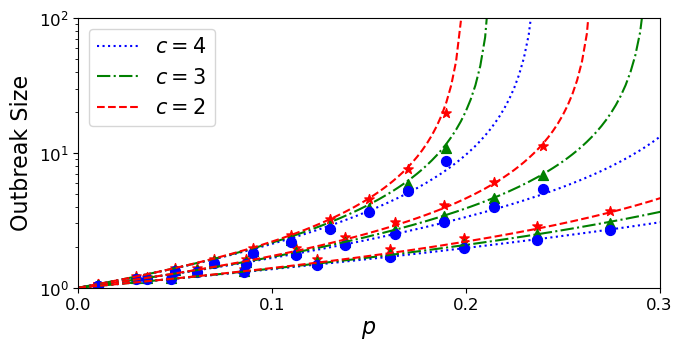

In [4]:
df = pd.read_csv('parsweep_cc_4.csv')

ens = 10**5
N = 10**5
average_degree = 6 
c_1_list = [2,3,4]

data_alpha0 = df[df.alpha < .001]
david_p = data_alpha0['p'].to_numpy(dtype=float)
e2 = data_alpha0['exp_size_2'].to_numpy(dtype=float)
e3 = data_alpha0['exp_size_3'].to_numpy(dtype=float)
e4 = data_alpha0['exp_size_4'].to_numpy(dtype=float)
E1 = [e2, e3, e4]

data_alpha25 = df[(df.alpha > .249) & (df.alpha < .251)]
david_p2 = data_alpha25['p'].to_numpy(dtype=float)
e22 = data_alpha25['exp_size_2'].to_numpy(dtype=float)
e32 = data_alpha25['exp_size_3'].to_numpy(dtype=float)
e42 = data_alpha25['exp_size_4'].to_numpy(dtype=float)
E2 = [e22, e32, e42]

data_alpha5 = df[(df.alpha > .499) & (df.alpha < .501)]
david_p3 = data_alpha5['p'].to_numpy(dtype=float)
e23 = data_alpha5['exp_size_2'].to_numpy(dtype=float)
e33 = data_alpha5['exp_size_3'].to_numpy(dtype=float)
e43 = data_alpha5['exp_size_4'].to_numpy(dtype=float)
E3 = [e23, e33, e43]

Es = [E1, E2, E3]
fig, axs = plt.subplots(figsize = (7.5,3.5))

    
cr = ['r', 'g', 'b']
lins = ['dashed', 'dashdot', 'dotted']
_i  = 0
_c  = 0
pss = [david_p, david_p2, david_p3]



p_range_alpha = []


for alpha in [0, 0.25, 0.5]:
    axs.plot(david_p3, Es[_i][2], color = cr[2],linestyle=lins[2], label = r'$c = 4$', ms = 15)
    axs.plot(david_p2, Es[_i][1],  color = cr[1],linestyle=lins[1], label = r'$c = 3$', ms = 15)
    axs.plot(david_p, Es[_i][0],  color = cr[0],linestyle=lins[0], label = r'$c = 2$', ms = 15)
        
    if alpha == 0:
        axs.legend(fontsize = 15)
        #Y_max = np.max(data[0])
    axs.set_xlim(0.0, .36)
    axs.set_ylim(1, 100)

    
    #axs.set_xscale('log')
    axs.set_yscale('log')

    axs.set_xlabel(r'$p$', fontsize = 16)
    axs.set_ylabel(r'Outbreak Size', fontsize = 16)
    axs.tick_params(axis='y', labelsize= 12)
    axs.tick_params(axis='x', labelsize= 12)
    plt.xticks([0, 0.1, .2, .3])

    _i += 1
    _c += 1

    
df2 = pd.read_csv('parsweep_cc_sim_results.csv')
data_alpha02 = df2[df2.alpha < .001]
david_ps2 = data_alpha02['p'].to_numpy(dtype=float)
e2S = data_alpha02['exp_size_2'].to_numpy(dtype=float)
e3S = data_alpha02['exp_size_3'].to_numpy(dtype=float)
e4S = data_alpha02['exp_size_4'].to_numpy(dtype=float)
E1S = [e2S, e3S, e4S]

data_alpha252 = df2[(df2.alpha > .249) & (df2.alpha < .251)]
david_p22 = data_alpha252['p'].to_numpy(dtype=float)
e22S = data_alpha252['exp_size_2'].to_numpy(dtype=float)
e32S = data_alpha252['exp_size_3'].to_numpy(dtype=float)
e42S = data_alpha252['exp_size_4'].to_numpy(dtype=float)
E2S = [e22S, e32S, e42S]

data_alpha52 = df2[(df2.alpha > .499) & (df2.alpha < .501)]
david_p32 = data_alpha52['p'].to_numpy(dtype=float)
e23S = data_alpha52['exp_size_2'].to_numpy(dtype=float)
e33S = data_alpha52['exp_size_3'].to_numpy(dtype=float)
e43S = data_alpha52['exp_size_4'].to_numpy(dtype=float)
E3S = [e23S, e33S, e43S]

EsS = [E1S, E2S, E3S]
_i  = 0
_c  = 0

p_range_alpha = []
markers = ['*', '^', 'o']

for alpha in [0, 0.25, 0.5]:
    axs.scatter(david_p32, EsS[_i][2], color = cr[_c], marker = markers[_c],  s = 50)
    axs.scatter(david_p22, EsS[_i][1],  color = cr[_c], marker =  markers[_c],  s = 50)
    axs.scatter(david_ps2, EsS[_i][0],  color = cr[_c], marker =  markers[_c],  s = 50)
    
        #Y_max = np.max(data[0])
    axs.set_xlim(0.0, .3)
    axs.set_ylim(1, 100)

    
    #axs.set_xscale('log')
    axs.set_yscale('log')

    axs.set_xlabel(r'$p$', fontsize = 16)
    axs.set_ylabel(r'Outbreak Size', fontsize = 16)
    axs.tick_params(axis='y', labelsize= 12)
    axs.tick_params(axis='x', labelsize= 12)
    plt.xticks([0, 0.1, .2, .3])

    _i += 1
    _c += 1


plt.savefig('11.pdf',bbox_inches='tight')